In [1]:
import numpy as np
from sklearn import datasets
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import plotly.graph_objects as go



Iris dataset contains a few features and the Iris type (Classification)

In [2]:
iris = datasets.load_iris()
X = iris.data
input_size = X.shape[-1]
y = iris.target
cats = np.max(y)+1

print(type(X))

<class 'numpy.ndarray'>


/tmp/ipykernel_18/2608776504.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  pd.plotting.scatter_matrix(df, figsize=(12,12), c=y, s=200, alpha=1, ax=ax)


array([[<Axes: xlabel='sepal length (cm)', ylabel='sepal length (cm)'>,
        <Axes: xlabel='sepal width (cm)', ylabel='sepal length (cm)'>,
        <Axes: xlabel='petal length (cm)', ylabel='sepal length (cm)'>,
        <Axes: xlabel='petal width (cm)', ylabel='sepal length (cm)'>],
       [<Axes: xlabel='sepal length (cm)', ylabel='sepal width (cm)'>,
        <Axes: xlabel='sepal width (cm)', ylabel='sepal width (cm)'>,
        <Axes: xlabel='petal length (cm)', ylabel='sepal width (cm)'>,
        <Axes: xlabel='petal width (cm)', ylabel='sepal width (cm)'>],
       [<Axes: xlabel='sepal length (cm)', ylabel='petal length (cm)'>,
        <Axes: xlabel='sepal width (cm)', ylabel='petal length (cm)'>,
        <Axes: xlabel='petal length (cm)', ylabel='petal length (cm)'>,
        <Axes: xlabel='petal width (cm)', ylabel='petal length (cm)'>],
       [<Axes: xlabel='sepal length (cm)', ylabel='petal width (cm)'>,
        <Axes: xlabel='sepal width (cm)', ylabel='petal width (cm)'>,
  

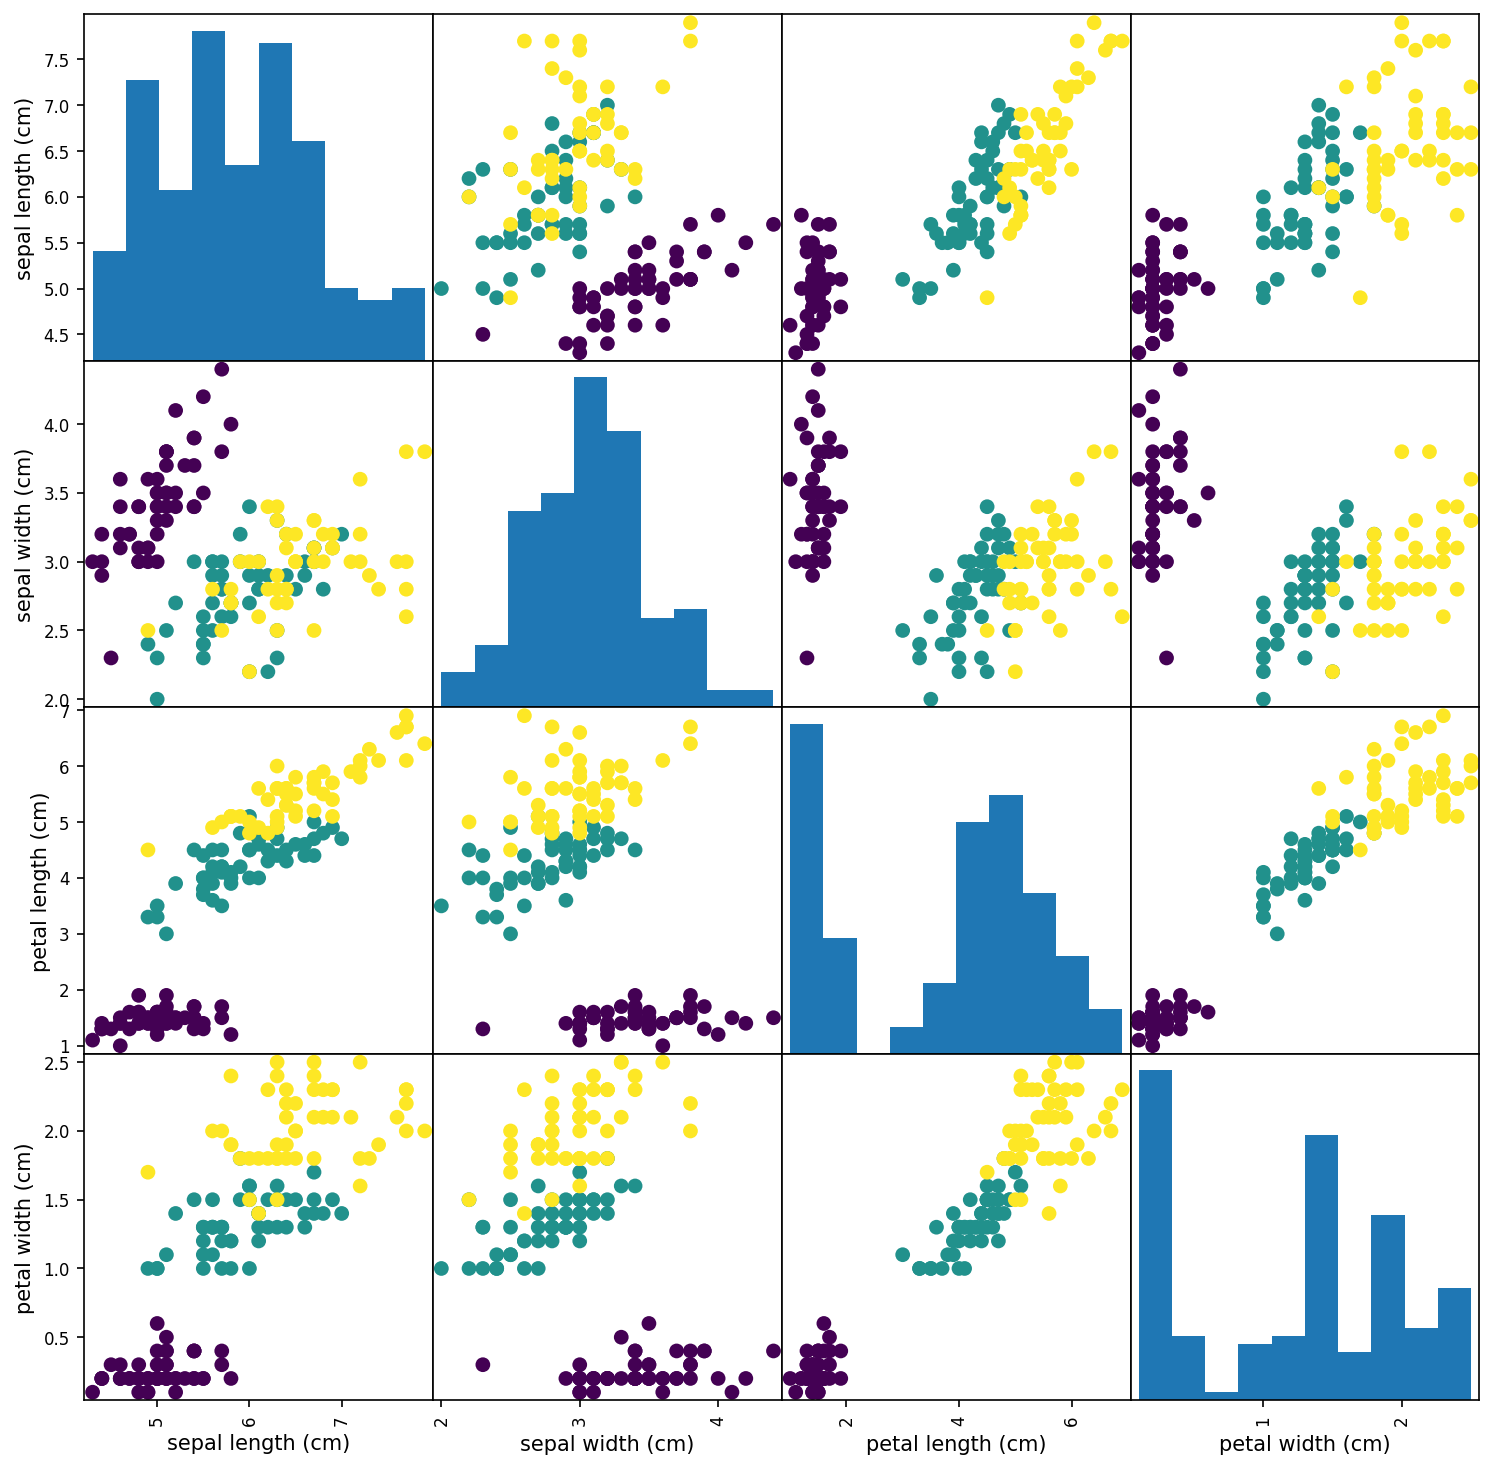

In [3]:
df = pd.DataFrame({k:X[:,i] for i,k in enumerate(iris['feature_names'])})
fig, ax = plt.subplots(figsize=(12,12), dpi=150)
pd.plotting.scatter_matrix(df, figsize=(12,12), c=y, s=200, alpha=1, ax=ax)

Leave some data for test, to make sure the model isn't overfitting for the training data. We didn't do on chapter 1 for simplicity. Some best practices even split to 3: train, validation, and test, where validation is used to compare different methods and test is the final test

In [4]:
# Reusing multiple functions from 1st chapter
# TODO: use fast-ai to automatically build library out of the notebook
class GeneralFit(nn.Module):
    def __init__(self, input_size, output_size, hidden_size=100):
        super().__init__()
        self.linear_in = nn.Linear(input_size, hidden_size)
        self.hidden = nn.Linear(hidden_size, hidden_size)
        self.linear_out = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x = torch.relu(self.linear_in(x))
        x = torch.relu(self.hidden(x))
        y = self.linear_out(x)
        
        return y

def fit(x_train, y_train, x_test, y_test, model, criterion, optimizer, num_epochs):
    """
    Train the `model` with the train dataset `(x_train, y_train)`
    'criterion' in the function used to calculate the loss
    `optimizer` changes the model weights based on the loss
    returns output, loss, and accuracy history for both the training and test datasets respectively
    """
    def accuracy_multi(prediction, y):
        """
        Given multi class prediction as `x` and ground truth as `y`, returns accuracy
        """
        return (prediction.argmax(-1) == y).float().mean()
    
    loss_history_train = []
    loss_history_test = []
    
    out_history_train = []
    out_history_test = []
    
    accuracy_history_train = []
    accuracy_history_test = []
    
    first_iteration = True
    
    for epoch in range(num_epochs):
        # forward pass
        model.train()
        outputs = model(x_train)
        loss = criterion(outputs, y_train)
        accuracy_train = accuracy_multi(outputs, y_train)
        
        # backward pass
        optimizer.zero_grad()
        # what exactly is done on this step
        loss.backward()
        # How the optimizer is aware of the loss
        optimizer.step()
        
        #test
        model.eval()
        test_output = model(x_test)
        test_loss = criterion(test_output, y_test)
        accuracy_test = accuracy_multi(test_output, y_test)
        
        loss_history_train.append(loss.item())
        loss_history_test.append(test_loss.item())
        
        accuracy_history_train.append(accuracy_train)
        accuracy_history_test.append(accuracy_test)
        
        if first_iteration:
            out_history_train = outputs.detach().numpy()
            out_history_test = test_output.detach().numpy()
            first_iteration=False
        else:
            out_history_train = np.concatenate((out_history_train, outputs.detach().numpy()), axis=1)
            out_history_test = np.concatenate((out_history_test, test_output.detach().numpy()), axis=1)
        #print('Epoch {}/{}, Loss {:.6f}'.format(epoch, num_epochs, loss.item()))
    
    return (out_history_train, out_history_test, loss_history_train, loss_history_test, accuracy_history_train, accuracy_history_test)

def plotly_loss_over_time(loss_history_train, loss_history_test=None, title=''):
    # what happens to the loss over epochs
    x=[i for i in range(len(loss_history_train))]
    loss_fig = go.Figure()
    loss_fig.add_trace(go.Scatter(x=x,y=loss_history_train, mode='lines', name=f'Train {title}', line=dict(color='red') ))
    if loss_history_test:
        loss_fig.add_trace(go.Scatter(x=x,y=loss_history_test, mode='lines', name=f'Test {title}', line=dict(color='green') ))
        
    loss_fig.update_layout(
        title=title,
        xaxis_title='Epoch',
        yaxis_title='Loss',
        legend=dict(x=0.01, y=0.99, bgcolor='rgba(255,200,255,0.5)'),
        showlegend=True
    )
    loss_fig.show()
        

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=2020)
x_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).long()
x_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).long()

In [6]:
# input size is number of features and output size is number of classes
# Q: We could have output size be 1 and each number will represent different class
model = GeneralFit(input_size, cats)
# Q: What is CrossEntropyLoss? How is it different than MSE and when it makes sense to use each
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
%time (out_history_train, out_history_test, loss_history_train, loss_history_test, accuracy_history_train, accuracy_history_test) = fit(x_train, y_train, x_test, y_test, model, criterion, optimizer, num_epochs=1000)

CPU times: user 4.54 s, sys: 51.9 ms, total: 4.59 s
Wall time: 2.43 s


In [7]:
plotly_loss_over_time(loss_history_train, loss_history_test, 'Loss per Epoch')

In [8]:
plotly_loss_over_time(accuracy_history_train, accuracy_history_test, 'Accuracy per Epoch')

We can see the impact of overfitting above, where from around epoch 250 the test loss is increasing (And accuracy is decreasing accordingly), whil it keeps improving for the train dataset